# Luminar

In [1]:
import warnings

warnings.filterwarnings("ignore", message=r".*Please note that with a fast tokenizer.*")
warnings.filterwarnings(
    "ignore",
    message=r".*Using the `WANDB_DISABLED` environment variable is deprecated.*",
)
warnings.filterwarnings(
    "ignore",
    message=r".*Was asked to gather along dimension \d+, but all input tensors were scalars.*",
)

In [2]:
import gc
import json

import numpy as np
from datasets import Dataset, DatasetDict, load_dataset
from tqdm.auto import tqdm

## Baselines: Neural Network Models

### Data

In [3]:
from pathlib import Path

from luminar.utils import get_matched_datasets

HF_TOKEN = (Path.home() / ".hf_token").read_text().strip()

agent = "gpt_4o_mini"
other_agents = "gemma2_9b"
datasets = {}
num_proc = 32
for domain in tqdm(
    [
        "blog_authorship_corpus",
        "student_essays",
        "cnn_news",
        "euro_court_cases",
        "house_of_commons",
        "arxiv_papers",
        "gutenberg_en",
        "bundestag",
        "spiegel_articles",
        # "gutenberg_de",
        "en",
        "de",
    ]
):
    datset_config_name = f"{domain}-fulltext"
    dataset_split_name = f"human+{agent}+{other_agents}"
    dataset: Dataset = (
        load_dataset(
            "liberi-luminaris/PrismAI",
            datset_config_name,
            split=dataset_split_name,
            token=HF_TOKEN,
        )  # type: ignore
        .rename_column("label", "labels")
        .filter(
            lambda text: len(text.strip()) > 0,
            input_columns=["text"],
            num_proc=num_proc,
        )
    )
    datasets_matched, dataset_unmatched = get_matched_datasets(
        dataset, agent, num_proc=num_proc
    )
    datasets_matched["unmatched"] = dataset_unmatched
    datasets[domain] = datasets_matched
del dataset
datasets

  0%|          | 0/11 [00:00<?, ?it/s]

{'blog_authorship_corpus': DatasetDict({
     train: Dataset({
         features: ['agent', 'id_sample', 'id_source', 'labels', 'text'],
         num_rows: 6406
     })
     eval: Dataset({
         features: ['agent', 'id_sample', 'id_source', 'labels', 'text'],
         num_rows: 914
     })
     test: Dataset({
         features: ['agent', 'id_sample', 'id_source', 'labels', 'text'],
         num_rows: 1832
     })
     unmatched: Dataset({
         features: ['agent', 'id_sample', 'id_source', 'labels', 'text'],
         num_rows: 24280
     })
 }),
 'student_essays': DatasetDict({
     train: Dataset({
         features: ['agent', 'id_sample', 'id_source', 'labels', 'text'],
         num_rows: 50734
     })
     eval: Dataset({
         features: ['agent', 'id_sample', 'id_source', 'labels', 'text'],
         num_rows: 7248
     })
     test: Dataset({
         features: ['agent', 'id_sample', 'id_source', 'labels', 'text'],
         num_rows: 14496
     })
     unmatched: Dataset

### RoBERTa

In [7]:
import torch
from transformers.training_args import TrainingArguments

from luminar.baselines.trainable import AutoClassifier
from luminar.baselines.core import run_detector, run_detector_tokenized


def run_finetuning(model: AutoClassifier, only_eval=False, cross_eval=False):
    model_name_or_path = model.model_name_or_path

    try:
        model_str = model_name_or_path.replace("/", "--").replace(":", "--")
        if model.freeze_lm:
            model_str += "-frozen"

        output_path = Path("../models/finetuning/") / model_str

        logs_path = Path("../logs/finetuning/") / model_str
        logs_path.mkdir(parents=True, exist_ok=True)

        tokenizer = model.tokenizer

        datasets_tokenized = {
            config: dataset.map(
                lambda texts: tokenizer(
                    texts,
                    padding=False,
                    truncation=True,
                    max_length=512,
                    return_length=True,
                ),
                input_columns=["text"],
                batched=True,
                batch_size=1024,
                desc="Tokenizing",
                keep_in_memory=True,
                num_proc=8,
            ).sort("length")
            for config, dataset in (
                datasets.items()
                if not only_eval
                else (
                    # We can omit training & dev splits if we are only evaluating
                    (config, DatasetDict({"test": dataset["test"]}))
                    for config, dataset in datasets.items()
                )
            )
        }

        tq = tqdm(
            datasets_tokenized.items(),
            desc="Evaluating" if only_eval else "Finetuning",
        )
        scores_fine_tuning = {}
        for config, dataset in tq:
            tq.set_postfix_str(config)

            output_dir = output_path / config
            final_model_path = output_dir / "final"
            if not only_eval:
                model.reset()
                training_args = TrainingArguments(
                    output_dir=str(output_dir),
                    seed=42,
                    #
                    learning_rate=1e-5,
                    num_train_epochs=3,
                    #
                    per_device_train_batch_size=15,
                    per_device_eval_batch_size=30,
                    #
                    logging_steps=50,
                    logging_strategy="steps",
                    eval_steps=50,
                    eval_strategy="steps",
                    save_strategy="epoch",
                    save_total_limit=2,
                )
                model.train(
                    dataset,
                    training_args,
                    save_path=str(final_model_path),
                )
            else:
                cls: type[AutoClassifier] = type(model)

                model.model.to("cpu")
                del model

                model = cls(
                    final_model_path,
                    tokenizer_name=model_name_or_path,
                    device="cuda:1",
                )

            scores_fine_tuning[config] = run_detector_tokenized(
                model,
                datasets_tokenized if cross_eval else {config: dataset},
                sigmoid=False,
                less_than=False,
            )
            with (logs_path / f"{config}.json").open("w") as fp:
                json.dump(scores_fine_tuning[config], fp, indent=4)

        return scores_fine_tuning
    finally:
        model.model.to("cpu")
        del model
        gc.collect()
        torch.cuda.synchronize()
        torch.cuda.empty_cache()
        gc.collect()


In [5]:
# scores_roberta_base_ft = run_finetuning(
#     RoBERTaClassifier("roberta-base", freeze_lm=True),
#     only_eval=False,
#     cross_eval=True,
# )
# print(json.dumps(scores_roberta_base_ft, indent=4))
# with open("../logs/finetuning/roberta-base-ft-frozen.json", "w") as fp:
#     json.dump(scores_roberta_base_ft, fp, indent=4)

In [ ]:
from luminar.baselines.trainable.roberta import RoBERTaClassifier

scores_roberta_base_ft = run_finetuning(
    RoBERTaClassifier("roberta-base", freeze_lm=True),
    only_eval=True,
    cross_eval=True,
)
print(json.dumps(scores_roberta_base_ft, indent=4))
with open("../logs/finetuning/roberta-base-ft-frozen.json", "w") as fp:
    json.dump(scores_roberta_base_ft, fp, indent=4)

## Evaluation

In [3]:
domains = [
    "Web Blogs",
    "Essays",
    "CNN",
    "ECHR",
    "HoC",
    "arXiv",
    "Gutenberg$_{en}$",
    "Bundestag$_{de}$",
    "Spiegel$_{de}$",
    # "Gutenberg$_{de}$",
    "All$_{en}$",
    "All$_{de}$",
]

name_map = {
    "blog_authorship_corpus": "Web Blogs",
    "student_essays": "Essays",
    "cnn_news": "CNN",
    "euro_court_cases": "ECHR",
    "house_of_commons": "HoC",
    "arxiv_papers": "arXiv",
    "gutenberg_en": "Gutenberg$_{en}$",
    "bundestag": "Bundestag$_{de}$",
    "spiegel_articles": "Spiegel$_{de}$",
    # "gutenberg_de": "Gutenberg$_{de}$",
    "en": "All$_{en}$",
    "de": "All$_{de}$",
}


order = {
    "Web Blogs": 1,
    "Essays": 2,
    "CNN": 3,
    "ECHR": 4,
    "HoC": 5,
    "arXiv": 6,
    "Gutenberg$_{en}$": 7,
    "Bundestag$_{de}$": 8,
    "Spiegel$_{de}$": 9,
    "de": 10,
    "en": 11,
}

In [5]:
import json
from collections import defaultdict
from pathlib import Path

import pandas as pd

results = defaultdict(dict)
for logs_path in Path("../logs/").iterdir():
    if logs_path.suffix == ".json":
        with logs_path.open("r") as fp:
            data = json.load(fp)
        model_name = logs_path.stem
        for domain, scores in data.items():
            results[name_map[domain]].update(
                {
                    model_name + "_f1_score": scores["f1_score"],
                    # model_name + "_accuracy": scores["accuracy"],
                    # model_name + "_tpr": scores["tpr"],
                    # model_name + "_roc_auc": scores["roc_auc"],
                }
            )

model_name = "roberta-base-ft-frozen"
for domain, name in name_map.items():
    logs_path = Path("../logs/finetuning/roberta-base-frozen") / (domain + ".json")
    with (logs_path).open("r") as fp:
        data = json.load(fp)
    domain_data = data.pop(domain)
    results[name].update(
        {
            model_name + "_f1_score": domain_data["f1_score"],
            # # model_name + "_accuracy": domain_data["accuracy"],
            # model_name + "_tpr": domain_data["tpr"],
            # # model_name + "_roc_auc": domain_data["roc_auc"],
        }
    )

for domain, name in name_map.items():
    logs_path = Path("../logs/luminar_cnn/gpt2") / domain / "metrics_test.json"
    with (logs_path).open("r") as fp:
        data = json.load(fp)
    results[name_map[domain]].update({
        "luminar_cnn_f1_score": data["test_f1_score"],
        # # "luminar_cnn_accuracy": data["test_accuracy"],
        # "luminar_cnn_tpr": data["test_tpr"],
        # # "luminar_cnn_roc_auc": data["test_roc_auc"],
    })

metric_df = (
    pd.DataFrame([{"domain": domain, "order": order.get(domain, 9999)} | dd for domain, dd in results.items()])
    .set_index("domain")
    .sort_index(key=lambda x: list(map(domains.index, x)))
    .round(3).sort_values("order").drop(columns=["order"])
)
print(metric_df.to_latex(float_format="%.3f", index=True))
metric_df

\begin{tabular}{lrrrrrr}
\toprule
 & binoculars_f1_score & e5-small-lora_f1_score & radar_f1_score & roberta-Hello-SimpleAI_f1_score & roberta-base-ft-frozen_f1_score & luminar_cnn_f1_score \\
domain &  &  &  &  &  &  \\
\midrule
Web Blogs & 0.823 & 0.624 & 0.413 & 0.678 & 0.940 & 0.796 \\
Essays & 0.991 & 0.511 & 0.299 & 0.610 & 0.990 & 0.949 \\
CNN & 0.992 & 0.596 & 0.201 & 0.649 & 0.963 & 0.930 \\
ECHR & 0.945 & 0.372 & 0.416 & 0.445 & 0.995 & 0.989 \\
HoC & 0.981 & 0.823 & 0.159 & 0.544 & 0.978 & 0.951 \\
arXiv & 0.997 & 0.517 & 0.273 & 0.411 & 0.852 & 0.971 \\
Gutenberg$_{en}$ & 0.992 & 0.936 & 0.270 & 0.464 & 0.928 & 0.887 \\
Bundestag$_{de}$ & 0.956 & 0.377 & 0.373 & 0.333 & 0.944 & 0.969 \\
Spiegel$_{de}$ & 0.907 & 0.622 & 0.335 & 0.335 & 0.786 & 0.686 \\
All$_{en}$ & 0.978 & 0.569 & 0.290 & 0.591 & 0.969 & 0.870 \\
All$_{de}$ & 0.927 & 0.560 & 0.360 & 0.336 & 0.834 & 0.839 \\
\bottomrule
\end{tabular}



,binoculars_f1_score,e5-small-lora_f1_score,radar_f1_score,roberta-Hello-SimpleAI_f1_score,roberta-base-ft-frozen_f1_score,luminar_cnn_f1_score
domain,,,,,,
Web Blogs,0.823,0.624,0.413,0.678,0.940,0.796
Essays,0.991,0.511,0.299,0.610,0.990,0.949
CNN,0.992,0.596,0.201,0.649,0.963,0.930
ECHR,0.945,0.372,0.416,0.445,0.995,0.989
HoC,0.981,0.823,0.159,0.544,0.978,0.951
arXiv,0.997,0.517,0.273,0.411,0.852,0.971
Gutenberg$_{en}$,0.992,0.936,0.270,0.464,0.928,0.887
Bundestag$_{de}$,0.956,0.377,0.373,0.333,0.944,0.969
Spiegel$_{de}$,0.907,0.622,0.335,0.335,0.786,0.686


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_heatmap(_df: pd.DataFrame, domains: list[str]):
    ax = sns.heatmap(
        _df,
        annot=True,
        fmt=".2f",
        vmax=1.0,
        vmin=0.0,
        cmap=sns.cubehelix_palette(rot=-0.2, as_cmap=True),
        yticklabels=list(domains),
        xticklabels=list(domains) + ["AVG"],
        square=True,
        # reduce annotation font size
        annot_kws={"fontsize": 8},
        cbar=False,
    )

    # rotate x-axis labels by 45 degrees
    # anchored at the right edge of the axes
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment("right")

    plt.tight_layout()
    plt.show()

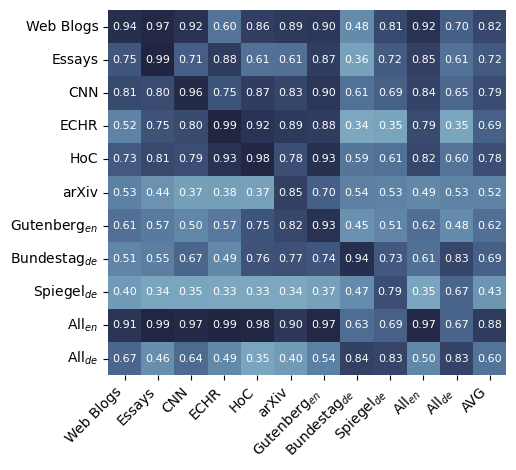

In [ ]:
roberta_ft_frozen_cross_domain = []
keys, names = zip(*name_map.items())

for domain in keys:
    logs_path = Path("../logs/finetuning/roberta-base-frozen") / (domain + ".json")
    with (logs_path).open("r") as fp:
        data = json.load(fp)
    roberta_ft_frozen_cross_domain.append([data[dm]["f1_score"] for dm in keys])

df_ = pd.DataFrame(roberta_ft_frozen_cross_domain, columns=names, index=names).round(3)
df_["AVG"] = df_.mean(axis=1)
plot_heatmap(df_, names)

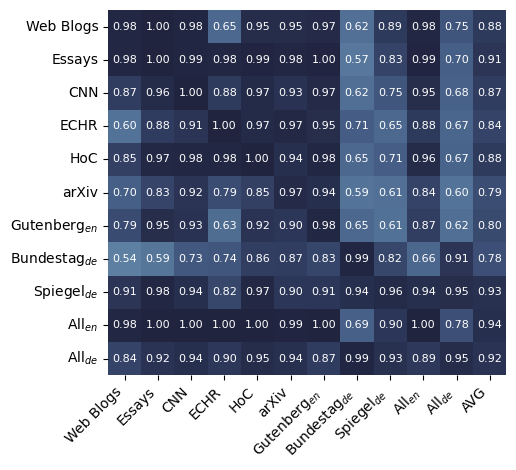

In [16]:
roberta_ft_frozen_cross_domain = []
keys, names = zip(*name_map.items())

for domain in keys:
    logs_path = Path("../logs/finetuning/roberta-base-frozen") / (domain + ".json")
    with (logs_path).open("r") as fp:
        data = json.load(fp)
    roberta_ft_frozen_cross_domain.append([data[dm]["roc_auc"] for dm in keys])

df_ = pd.DataFrame(roberta_ft_frozen_cross_domain, columns=names, index=names).round(3)
df_["AVG"] = df_.mean(axis=1)
plot_heatmap(df_, names)

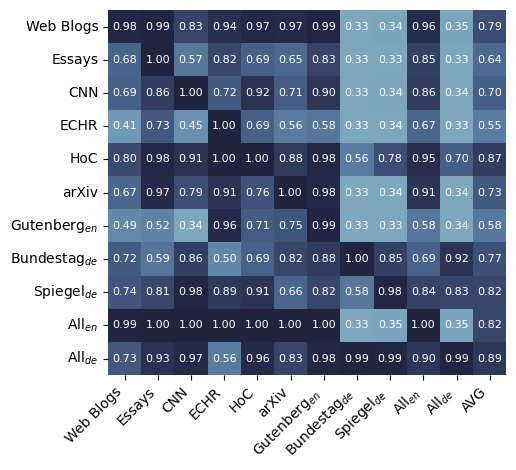

In [11]:
roberta_ft_frozen_cross_domain = []
keys, names = zip(*name_map.items())
for domain in keys:
    logs_path = Path("../logs/finetuning/roberta-base") / (domain + ".json")
    with (logs_path).open("r") as fp:
        data = json.load(fp)
    roberta_ft_frozen_cross_domain.append([data[dm]["f1_score"] for dm in keys])

df = pd.DataFrame(roberta_ft_frozen_cross_domain, columns=names, index=names).round(3)
df["AVG"] = df.mean(axis=1)
plot_heatmap(df, names)

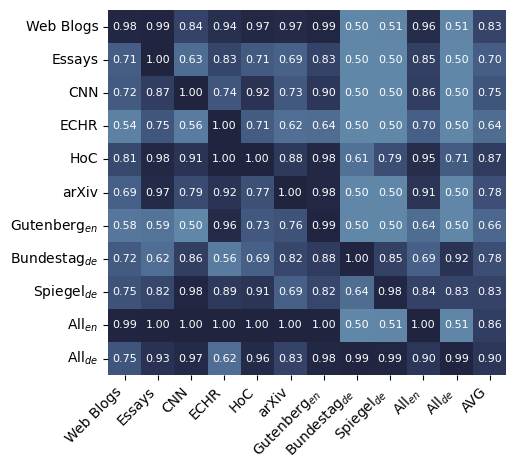

In [10]:
roberta_ft_frozen_cross_domain = []
keys, names = zip(*name_map.items())
for domain in keys:
    logs_path = Path("../logs/finetuning/roberta-base") / (domain + ".json")
    with (logs_path).open("r") as fp:
        data = json.load(fp)
    roberta_ft_frozen_cross_domain.append([data[dm]["roc_auc"] for dm in keys])

df = pd.DataFrame(roberta_ft_frozen_cross_domain, columns=names, index=names).round(3)
df["AVG"] = df.mean(axis=1)
plot_heatmap(df, names)

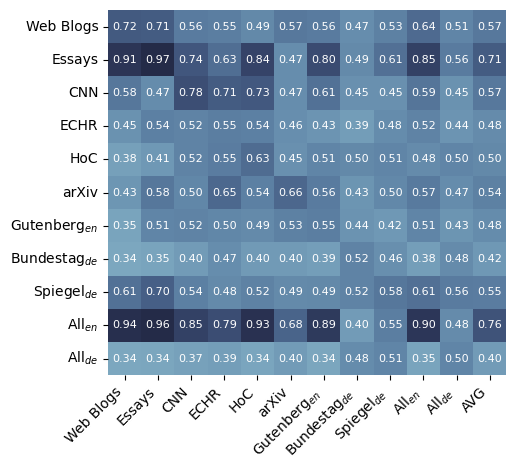

In [6]:
model_name = "gpt2-ft-frozen"
logs_path = Path("../logs/finetuning/gpt2-ft-frozen.json")
with (logs_path).open("r") as fp:
    gpt2_data = json.load(fp)

gpt2_frozen_cross_domain = []
keys, names = zip(*name_map.items())
for domain in keys:
    domain_data = gpt2_data[domain]
    gpt2_frozen_cross_domain.append([domain_data[dm]["f1_score"] for dm in keys])

df = pd.DataFrame(gpt2_frozen_cross_domain, columns=names, index=names).round(3)
df["AVG"] = df.mean(axis=1)
plot_heatmap(df, names)

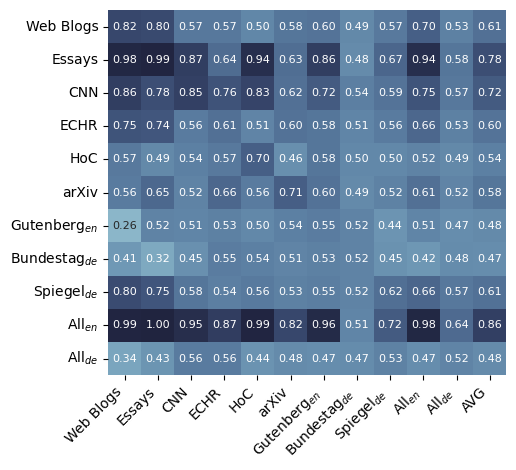

In [7]:
model_name = "gpt2-ft-frozen"
logs_path = Path("../logs/finetuning/gpt2-ft-frozen.json")
with (logs_path).open("r") as fp:
    gpt2_data = json.load(fp)

gpt2_frozen_cross_domain = []
keys, names = zip(*name_map.items())
for domain in keys:
    domain_data = gpt2_data[domain]
    gpt2_frozen_cross_domain.append([domain_data[dm]["roc_auc"] for dm in keys])

df = pd.DataFrame(gpt2_frozen_cross_domain, columns=names, index=names).round(3)
df["AVG"] = df.mean(axis=1)
plot_heatmap(df, names)

In [9]:
import json
from collections import defaultdict
from pathlib import Path

import pandas as pd

results = defaultdict(dict)
for logs_path in Path("../logs/").iterdir():
    if logs_path.suffix == ".json":
        with logs_path.open("r") as fp:
            data = json.load(fp)
        model_name = logs_path.stem
        for domain, scores in data.items():
            results[name_map[domain]].update(
                {
                    model_name + "_f1_score": scores["f1_score"],
                    model_name + "_accuracy": scores["accuracy"],
                    model_name + "_roc_auc": scores["roc_auc"],
                }
            )

model_name = "roberta-base-ft"
for domain, name in name_map.items():
    logs_path = Path("../logs/finetuning/roberta-base/") / (domain + ".json")
    with (logs_path).open("r") as fp:
        data = json.load(fp)
    results[name].update(
        {
            model_name + "_f1_score": data[domain]["f1_score"],
            model_name + "_accuracy": data[domain]["accuracy"],
            model_name + "_roc_auc": data[domain]["roc_auc"],
        }
    )

model_name = "gpt2-ft-frozen"
logs_path = Path("../logs/finetuning/gpt2-ft-frozen.json")
with (logs_path).open("r") as fp:
    gpt2_data = json.load(fp)
for domain, name in name_map.items():
    results[name].update(
        {
            model_name + "_f1_score": gpt2_data[domain][domain]["f1_score"],
            model_name + "_accuracy": gpt2_data[domain][domain]["accuracy"],
            model_name + "_roc_auc": gpt2_data[domain][domain]["roc_auc"],
        }
    )

metric_df = (
    pd.DataFrame([{"domain": domain} | dd for domain, dd in results.items()])
    .set_index("domain")
    .sort_index(key=lambda x: list(map(domains.index, x)))
)
print(metric_df.to_latex(float_format="%.3f", index=True))
metric_df

\begin{tabular}{lrrrrrrrrrrrrrrrrrr}
\toprule
 & binoculars_f1_score & binoculars_accuracy & binoculars_roc_auc & e5-small-lora_f1_score & e5-small-lora_accuracy & e5-small-lora_roc_auc & radar_f1_score & radar_accuracy & radar_roc_auc & roberta-Hello-SimpleAI_f1_score & roberta-Hello-SimpleAI_accuracy & roberta-Hello-SimpleAI_roc_auc & roberta-base-ft_f1_score & roberta-base-ft_accuracy & roberta-base-ft_roc_auc & gpt2-ft-frozen_f1_score & gpt2-ft-frozen_accuracy & gpt2-ft-frozen_roc_auc \\
domain &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Web Blogs & 0.823 & 0.825 & 0.825 & 0.624 & 0.662 & 0.662 & 0.413 & 0.430 & 0.430 & 0.678 & 0.703 & 0.703 & 0.981 & 0.981 & 0.981 & 0.724 & 0.734 & 0.819 \\
Essays & 0.991 & 0.991 & 0.991 & 0.511 & 0.591 & 0.591 & 0.299 & 0.327 & 0.327 & 0.610 & 0.628 & 0.628 & 0.999 & 0.999 & 0.999 & 0.966 & 0.966 & 0.994 \\
CNN & 0.992 & 0.992 & 0.992 & 0.596 & 0.646 & 0.646 & 0.201 & 0.242 & 0.242 & 0.649 & 0.676 & 0.676 & 0.999 & 0.999 & 0

,binoculars_f1_score,binoculars_accuracy,binoculars_roc_auc,e5-small-lora_f1_score,e5-small-lora_accuracy,e5-small-lora_roc_auc,radar_f1_score,radar_accuracy,radar_roc_auc,roberta-Hello-SimpleAI_f1_score,roberta-Hello-SimpleAI_accuracy,roberta-Hello-SimpleAI_roc_auc,roberta-base-ft_f1_score,roberta-base-ft_accuracy,roberta-base-ft_roc_auc,gpt2-ft-frozen_f1_score,gpt2-ft-frozen_accuracy,gpt2-ft-frozen_roc_auc
domain,,,,,,,,,,,,,,,,,,
Web Blogs,0.822865,0.825328,0.825328,0.623582,0.661572,0.661572,0.412882,0.429585,0.429585,0.678464,0.702511,0.702511,0.980894,0.980895,0.980895,0.724160,0.734170,0.819331
Essays,0.991445,0.991446,0.991446,0.510591,0.591336,0.591336,0.299054,0.327263,0.327263,0.609554,0.627897,0.627897,0.998896,0.998896,0.998896,0.965904,0.965922,0.994226
CNN,0.991536,0.991536,0.991536,0.596457,0.646424,0.646424,0.200990,0.241642,0.241642,0.648760,0.675624,0.675624,0.999365,0.999365,0.999365,0.778877,0.778883,0.852211
ECHR,0.945397,0.945551,0.945551,0.371981,0.517928,0.517928,0.416427,0.419655,0.419655,0.445330,0.555113,0.555113,1.000000,1.000000,1.000000,0.549419,0.556441,0.615006
HoC,0.980717,0.980721,0.980721,0.822936,0.828164,0.828164,0.158682,0.158843,0.158843,0.544177,0.611065,0.611065,0.997904,0.997904,0.997904,0.633890,0.636211,0.696649
arXiv,0.996516,0.996516,0.996516,0.517223,0.595819,0.595819,0.273349,0.365854,0.365854,0.411220,0.537282,0.537282,0.998955,0.998955,0.998955,0.657823,0.657840,0.707438
Gutenberg$_{en}$,0.991582,0.991582,0.991582,0.935817,0.936027,0.936027,0.269943,0.316498,0.316498,0.463553,0.563973,0.563973,0.993266,0.993266,0.993266,0.548084,0.548822,0.552461
Bundestag$_{de}$,0.955699,0.955765,0.955765,0.377365,0.438121,0.438121,0.372983,0.504225,0.504225,0.333333,0.500000,0.500000,0.996024,0.996024,0.996024,0.516657,0.516899,0.522535
Spiegel$_{de}$,0.907124,0.907793,0.907793,0.622337,0.630967,0.630967,0.335255,0.496328,0.496328,0.334692,0.500612,0.500612,0.977345,0.977356,0.977356,0.580317,0.581599,0.617943


In [ ]:
import json
from collections import defaultdict
from pathlib import Path

import pandas as pd

results = defaultdict(dict)
for logs_path in Path("../logs/").iterdir():
    if logs_path.suffix == ".json":
        with logs_path.open("r") as fp:
            data = json.load(fp)
        model_name = logs_path.stem
        for domain, scores in data.items():
            results[name_map[domain]].update(
                {
                    model_name + "_f1_score": scores["f1_score_median"],
                    model_name + "_accuracy": scores["accuracy_median"],
                    model_name + "_roc_auc": scores["roc_auc_median"],
                }
            )

model_name = "roberta-base-ft"
for domain, name in name_map.items():
    logs_path = Path("../logs/roberta-ft/roberta-base/") / (domain + ".json")
    with (logs_path).open("r") as fp:
        data = json.load(fp)
    results[name].update(
        {
            model_name + "_f1_score": data[domain]["f1_score_median"],
            model_name + "_accuracy": data[domain]["accuracy_median"],
            model_name + "_roc_auc": data[domain]["roc_auc_median"],
        }
    )

metric_df = (
    pd.DataFrame([{"domain": domain} | dd for domain, dd in results.items()])
    .set_index("domain")
    .sort_index(key=lambda x: list(map(domains.index, x)))
)
print(metric_df.to_latex(float_format="%.3f", index=True))
metric_df

In [ ]:
import json
from collections import defaultdict
from pathlib import Path

import pandas as pd

results = defaultdict(dict)
for logs_path in Path("../logs/").iterdir():
    if logs_path.suffix == ".json":
        with logs_path.open("r") as fp:
            data = json.load(fp)
        model_name = logs_path.stem
        for domain, scores in data.items():
            results[name_map[domain]].update(
                {
                    model_name + "_f1_score": scores["f1_score_mean"],
                    model_name + "_accuracy": scores["accuracy_mean"],
                    model_name + "_roc_auc": scores["roc_auc_mean"],
                }
            )

model_name = "roberta-base-ft"
for domain, name in name_map.items():
    logs_path = Path("../logs/roberta-ft/roberta-base/") / (domain + ".json")
    with (logs_path).open("r") as fp:
        data = json.load(fp)
    results[name].update(
        {
            model_name + "_f1_score": data[domain]["f1_score_mean"],
            model_name + "_accuracy": data[domain]["accuracy_mean"],
            model_name + "_roc_auc": data[domain]["roc_auc_mean"],
        }
    )

metric_df = (
    pd.DataFrame([{"domain": domain} | dd for domain, dd in results.items()])
    .set_index("domain")
    .sort_index(key=lambda x: list(map(domains.index, x)))
)
print(metric_df.to_latex(float_format="%.3f", index=True))
metric_df

In [ ]:
results = defaultdict(dict)

model_name = "roberta-ft"
for domain, name in name_map.items():
    logs_path = Path("../logs/chatgpt-detector-roberta/") / (domain + ".json")
    with (logs_path).open("r") as fp:
        data = json.load(fp)
    results[name].update(
        {
            model_name + "_f1": data[domain]["f1"],
            # model_name + "_accuracy": data[domain]["accuracy"],
            model_name + "_auroc": data[domain]["auroc"],
        }
    )

metric_df = (
    pd.DataFrame([{"domain": domain} | dd for domain, dd in results.items()])
    .set_index("domain")
    .sort_index(key=lambda x: list(map(domains.index, x)))
)
print(metric_df.to_latex(float_format="%.3f", index=True))
metric_df